# Extraction of UDS from Neocortex recordings

Restarting from LFPwake0 and LFPwakeremoved.

LFPwakeremoved will be used to determined signal variance for threshold adjustement. 

LFPwake0 will be used for time determination. 

## Load LFP and packages

In [87]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy import fftpack
import pandas as pd
from pathlib import Path
import pywt
from scipy.signal import hilbert, butter, filtfilt
from scipy import fftpack
from scipy import stats
from scipy.signal import find_peaks
from scipy.signal import chirp, find_peaks, peak_widths
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import morlet2, spectrogram




%matplotlib widget

folder_base = Path('/Users/ahay/Documents/DATA/AHCR/Bleu/20240220/')
filename = folder_base / f'EMGframeBoolean.pkl'
filename3 = folder_base / f'LFPwakeremoved.npy'
filename2 = folder_base / f'RawDataChannelExtractedDS.npy'
#filenameSp = folder_base / f'timestamps.npy'

EMGboolean = pd.read_pickle(filename)
LFPwakeremoved = np.load(filename3, mmap_mode= 'r')
All = np.load(filename2, mmap_mode= 'r')
#TTL = np.load(filenameSp)
All = All
echantillonD = 0
echantillonF = int((All.shape[0]))
Cortex = All[echantillonD:echantillonF,0]- All[echantillonD:echantillonF, 1]
Cortexwakeremoved = LFPwakeremoved[echantillonD:echantillonF,0] - LFPwakeremoved[echantillonD:echantillonF,1]

EMGboolean = EMGboolean[echantillonD:echantillonF]
All.shape


(9653615, 32)

Remove DC

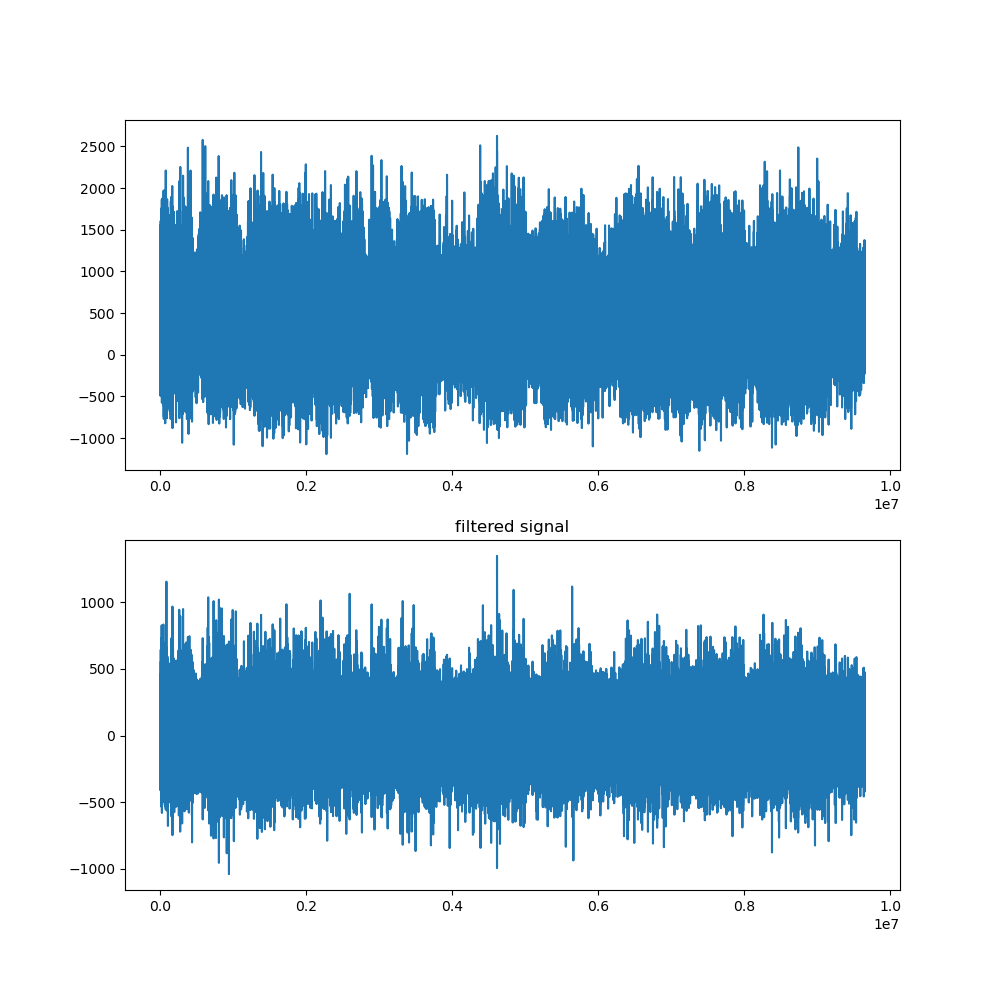

In [88]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt


def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

fps = 1000

# for most cortices set to 1, for RSP try higher frequency ~ 5Hz
fCortex = butter_highpass_filter(Cortex,20,fps)

plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(range(len(fCortex)),Cortex)
plt.subplot(212)
plt.plot(range(len(fCortex)),fCortex)
plt.title('filtered signal')
plt.show()

In [89]:
DCvalue = np.mean(fCortex)
fdcCortexNW = fCortex - DCvalue

morlet wavelet

j'ai testé, faire un rattrapage de 1/f pour du gamma n'a pas d'intérêt et est tout aussi bien fait par le zscorage. Donc autant prendre le zscorage
voir la fin du code 

In [90]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

sampling_period = 0.001
widths = np.geomspace(20, 60, num=45)
wavelet = "cmor1.5-1.0"
CortexNWcwt, freqs=pywt.cwt(fdcCortexNW,widths,wavelet, sampling_period=sampling_period)
cwtmatr = np.abs(CortexNWcwt[:-1, :-1])
time = np.arange(0,2,0.001)
CortexNWcwt = []

Readjustment zscorage (le 1/f n'a aucun intérêt)

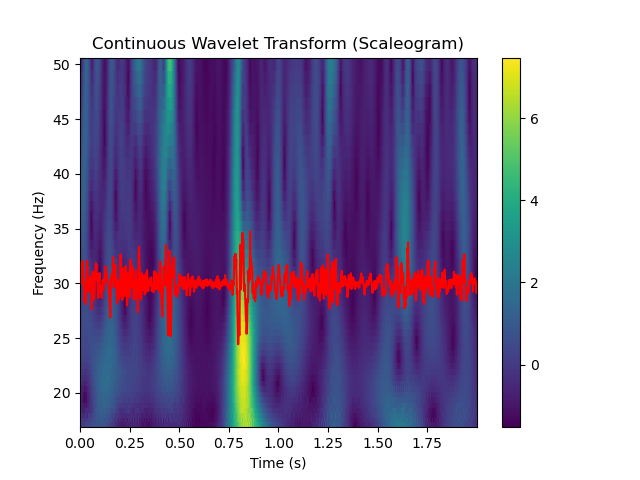

In [91]:
widths
zcwtmatr = stats.zscore(cwtmatr, axis=None)
zcwtmatr = stats.zscore(cwtmatr, axis=1)
zcwtmatr2 = zcwtmatr[:,75000:77000]

fig, axs = plt.subplots(1, 1)
pcm = axs.pcolormesh(time, freqs[0:44], zcwtmatr2)
axs.plot(time, fdcCortexNW[75000:77000]/100+30, "r")
axs.set_xlabel("Time (s)")
axs.set_ylabel("Frequency (Hz)")
axs.set_title("Continuous Wavelet Transform (Scaleogram)")
fig.colorbar(pcm, ax=axs)

multiplier la projection par le signal LFP inversé

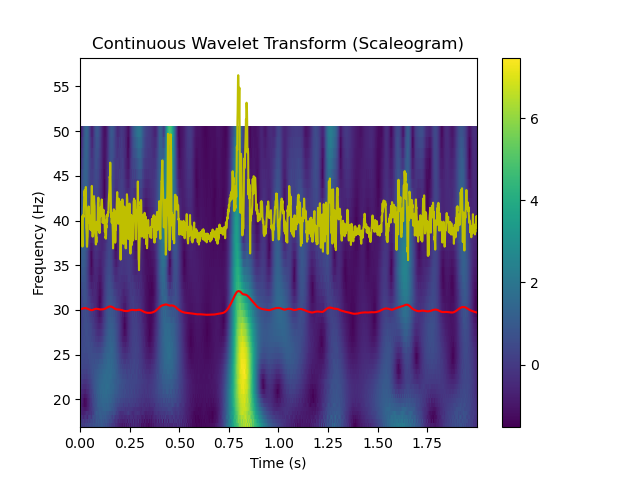

In [92]:
proj_zcwtmatr = np.sum(zcwtmatr, axis = 0)
proj_zcwtmatr = np.append(proj_zcwtmatr,0)
mixsignal = proj_zcwtmatr - (fdcCortexNW/2) # factor to be adjusted depending on how nice the raw signal is (2 for nice one such as M1, 10 for RSP for instance)

fig, axs = plt.subplots(1, 1)
pcm = axs.pcolormesh(time, freqs[0:44], zcwtmatr2)
axs.plot(time, proj_zcwtmatr[75000:77000]/100+30, "r")
axs.plot(time, mixsignal[75000:77000]/30+40, "y")

axs.set_xlabel("Time (s)")
axs.set_ylabel("Frequency (Hz)")
axs.set_title("Continuous Wavelet Transform (Scaleogram)")
fig.colorbar(pcm, ax=axs)

In [93]:
np.std(mixsignal)


57.067737302211704

Digitalise the signal

In [94]:
# Digitmixsignal = mixsignal
# putUDS = 0
# for var in range(mixsignal.shape[0]):
#     if mixsignal[var] > (-np.std(mixsignal)):
#         Digitmixsignal[var] = 0
#         if Digitmixsignal[var-1] == 1:
#             putUDS += 1
#     else:
#         Digitmixsignal[var] = 1

/var/folders/jq/nz6nvbd54ns2lkjvj31_7_4r0000gn/T/ipykernel_33426/3641991911.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 1)


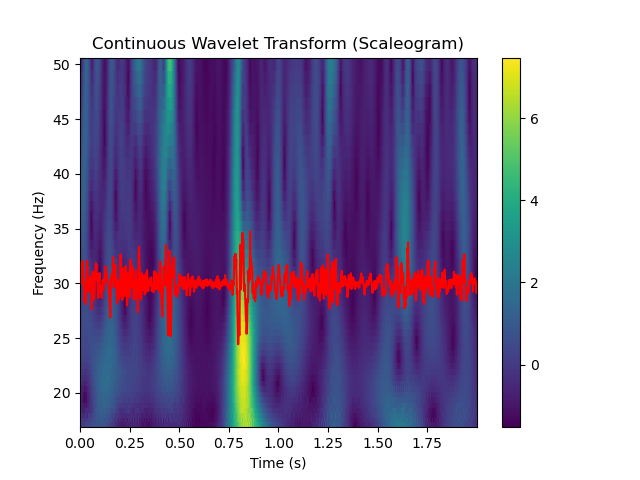

In [95]:
fig, axs = plt.subplots(1, 1)
pcm = axs.pcolormesh(time, freqs[0:44], zcwtmatr2)
axs.plot(time, fdcCortexNW[75000:77000]/100+30, "r")

axs.set_xlabel("Time (s)")
axs.set_ylabel("Frequency (Hz)")
axs.set_title("Continuous Wavelet Transform (Scaleogram)")
fig.colorbar(pcm, ax=axs)

In [96]:
cwtmatr = []
zcwtmatr = []

In [106]:


# Step 1: Compute the Digitmixsignal vector
threshold = -np.std(mixsignal)
Digitmixsignal = np.ones_like(mixsignal)  # Initialize with 1
Digitmixsignal[mixsignal > threshold] = 0  # Set 0 where condition is met

# # Count putative Down states transitions (1 -> 0)
# putUDS = np.sum((Digitmixsignal[:-1] == 1) & (Digitmixsignal[1:] == 0))

# # Initialize the UDS_Prop array based on the number of transitions
# UDS_Prop = np.zeros((putUDS + 1, 4))

# # Step 2: Find transitions using np.diff
# down_to_up = np.where((Digitmixsignal[:-1] == 0) & (Digitmixsignal[1:] == 1))[0] + 1
# up_to_down = np.where((Digitmixsignal[:-1] == 1) & (Digitmixsignal[1:] == 0))[0] + 1

# # If the signal starts with 1, set the first UDS_Prop entry to start at 0
# j6 = 0
# if Digitmixsignal[0] == 1:
#     UDS_Prop[j6, 0] = 0

# # Step 3: Loop over the transitions and populate UDS_Prop
# for dtu, utd in zip(down_to_up, up_to_down):
#     UDS_Prop[j6, 0] = dtu
#     UDS_Prop[j6, 1] = utd
#     UDS_Prop[j6, 2] = utd - dtu  # Duration of Up state
#     if j6 > 0:
#         UDS_Prop[j6, 3] = dtu - UDS_Prop[j6 - 1, 1]  # Interval between Down and next Up
#     j6 += 1

# # Step 4: Handle the case for the last element if it ends with an Up state
# if Digitmixsignal[-1] == 1:
#     UDS_Prop[j6, 1] = len(Digitmixsignal)
#     UDS_Prop[j6, 2] = UDS_Prop[j6, 1] - UDS_Prop[j6, 0]
#     if j6 > 0:
#         UDS_Prop[j6, 3] = UDS_Prop[j6, 0] - UDS_Prop[j6 - 1, 1]

# # Final Output
# print(putUDS)

In [107]:
np.mean(Digitmixsignal)

0.5911604098568256

### Extracting Down states and determining main properties 

In [130]:
threshold = -0.85*np.std(proj_zcwtmatr)
Digitmixsignal = np.ones_like(mixsignal)  # Initialize with 1
Digitmixsignal[proj_zcwtmatr > threshold] = 0  # Set 0 where condition is met

# Attribute 1 to putative Down states
numpnts = Digitmixsignal.size
        
# Initializing the array bilan
UDS_Prop = np.zeros((numpnts, 4))
print(numpnts)


# Loop for identifying transitions and updating bilan array
ic6 = 0
j6 = 0
while ic6 < (numpnts - 1):
    if Digitmixsignal[0] == 0:
        if Digitmixsignal[ic6] == 0 and Digitmixsignal[ic6 + 1] == 1:
            UDS_Prop[j6,0] = ic6
        elif Digitmixsignal[ic6] == 1 and Digitmixsignal[ic6 + 1] == 0:
            UDS_Prop[j6,1] = ic6
            UDS_Prop[j6,2] = UDS_Prop[j6,1] - UDS_Prop[j6,0]
            UDS_Prop[j6,3] = UDS_Prop[j6,0] - UDS_Prop[j6 - 1,1]
            j6 += 1
    elif Digitmixsignal[0] == 1:
        UDS_Prop[0,0] = 0
        if Digitmixsignal[ic6] == 0 and Digitmixsignal[ic6 + 1] == 1:
            UDS_Prop[j6,0] = ic6
        elif Digitmixsignal[ic6] == 1 and Digitmixsignal[ic6 + 1] == 0:
            UDS_Prop[j6,1] = ic6
            UDS_Prop[j6,2] = UDS_Prop[j6,1] - UDS_Prop[j6,0]
            UDS_Prop[j6,3] = UDS_Prop[j6,0] - UDS_Prop[j6 - 1,1]
            j6 += 1
    ic6 += 1

# Check for the last element
if Digitmixsignal[numpnts-1] == 1:
   UDS_Prop[j6,1] = numpnts
   UDS_Prop[j6,2] = UDS_Prop[j6,1] - UDS_Prop[j6,0]
   UDS_Prop[j6,3] = UDS_Prop[j6,0] - UDS_Prop[j6 - 1,1]

UDS_Prop.shape
toremove = numpnts - j6
UDS_Prop = UDS_Prop[:-toremove,:]
UDS_Prop.shape

9653615


(32853, 4)

In [131]:
pd_prop_UDS = pd.DataFrame(UDS_Prop, columns = ['start time', 'end time', 'Duration', 'Dur till next',])

nb_Downstate = UDS_Prop.shape[0]
print(nb_Downstate)
listtodrop = []
## on enlève tous les petits DS de moins de 40 ms.
for tt in range(nb_Downstate-1):
    if(pd_prop_UDS['Duration'][tt]<40):
        listtodrop.append(tt)

pd_prop_UDS.shape[0]
pd_prop_UDS = pd_prop_UDS.drop(listtodrop) 

# nb_Downstate = pd_prop_UDS.shape[0]
# listtodrop = []
# print(nb_Downstate)
# pd_prop_UDS.reset_index(inplace=True)
# pd_prop_UDS = pd_prop_UDS.drop('index', axis=1)

## on enlève tous les petits US de moins de 80 ms.
# for tt in range(nb_Downstate-1):
#     if(pd_prop_UDS['Dur till next'][tt]<120):
#         listtodrop.append(tt)

# pd_prop_UDS.shape[0]
# pd_prop_UDS = pd_prop_UDS.drop(listtodrop) 

# nb_Downstate = pd_prop_UDS.shape[0]
# listtodrop = []
# print(nb_Downstate)
# pd_prop_UDS.reset_index(inplace=True)
# pd_prop_UDS = pd_prop_UDS.drop('index', axis=1)

# for tt in range(nb_Downstate-1):
#     if(pd_prop_UDS['end time'][tt]>pd_prop_UDS['start time'][tt + 1]):
#         if(pd_prop_UDS['Duration'][tt]<pd_prop_UDS['Duration'][tt + 1]):
#             if(pd_prop_UDS['start time'][tt]<pd_prop_UDS['start time'][tt + 1]):
#                 pd_prop_UDS['start time'][tt+1] = pd_prop_UDS['start time'][tt]
#                 listtodrop.append(tt)
#             else:
#                 listtodrop.append(tt)
#         if(pd_prop_UDS['Duration'][tt]>pd_prop_UDS['Duration'][tt + 1]):
#             if(pd_prop_UDS['end time'][tt]<pd_prop_UDS['end time'][tt + 1]):
#                 pd_prop_UDS['end time'][tt] = pd_prop_UDS['end time'][tt + 1]
#                 listtodrop.append(tt+1)
#             else:
#                 listtodrop.append(tt+1)

# pd_prop_UDS.shape[0]
# pd_prop_UDS = pd_prop_UDS.drop(listtodrop) 

nb_Downstate = pd_prop_UDS.shape[0]
listtodrop = []
print(nb_Downstate)
pd_prop_UDS.reset_index(inplace=True)
pd_prop_UDS = pd_prop_UDS.drop('index', axis=1)



32853
14398


In [127]:


# # Duplicate the array bilan to bilan2
# UDS_Prop2 = UDS_Prop.copy()

# # Update bilan2 by removing small transitions

# ic7 = 0
# while ic7 < (putUDS-1):
#     if (UDS_Prop2[ic7][2] + UDS_Prop2[ic7][3]) < 40:
#         UDS_Prop2[ic7 - 1,1] = UDS_Prop2[ic7][1]
#         UDS_Prop2[ic7 - 1,2] = UDS_Prop2[ic7 - 1,1] - UDS_Prop2[ic7 - 1,0]
# #        UDS_Prop2[ic7 + 1,3] = UDS_Prop2[ic7 + 1,0] - UDS_Prop2[ic7 - 1,1]
#         UDS_Prop2 = np.delete(UDS_Prop2, ic7, axis=0)
#         putUDS -= 1
#         ic7 -=1
#     ic7 += 1

# print(putUDS)

# # pd_prop_UDS = pd.DataFrame(UDS_Prop2, columns = ['start time', 'end time', 'Duration', 'Dur till next',])
# # filename3 = folder_base / f'PFCUDSproperties1.csv'
# # pd_prop_UDS.to_csv(filename3, sep = ',')

# # # # Remove small up-states
# ic7 = 0
# while ic7 < (putUDS-1):
#     if UDS_Prop2[ic7][3] < 80:
#         UDS_Prop2[ic7 - 1,1] = UDS_Prop2[ic7,1]
#         UDS_Prop2[ic7 - 1,2] = UDS_Prop2[ic7 - 1,1] - UDS_Prop2[ic7 - 1,0]
# #        UDS_Prop2[ic7 + 1,3] = UDS_Prop2[ic7 + 1,0] - UDS_Prop2[ic7 - 1,1]
#         UDS_Prop2 = np.delete(UDS_Prop2, ic7, axis=0)
#         putUDS -= 1
#         ic7 -=1
#     ic7 += 1

# print(putUDS)

# # pd_prop_UDS = pd.DataFrame(UDS_Prop2, columns = ['start time', 'end time', 'Duration', 'Dur till next',])
# # filename3 = folder_base / f'PFCUDSproperties2.csv'
# # pd_prop_UDS.to_csv(filename3, sep = ',')

# # Remove too closed small down-states
# ic7 = 0
# while ic7 < (putUDS-1):
#     if UDS_Prop2[ic7,2] < 100:
# #        UDS_Prop2[ic7 - 1,1] = UDS_Prop2[ic7,1]
# #        UDS_Prop2[ic7 - 1,2] = UDS_Prop2[ic7 - 1,1] - UDS_Prop2[ic7 - 1,0]
#         UDS_Prop2[ic7 + 1,3] = UDS_Prop2[ic7 + 1,0] - UDS_Prop2[ic7 - 1,1]
#         UDS_Prop2 = np.delete(UDS_Prop2, ic7, axis=0)
#         putUDS -= 1
#         ic7 -=1
#     ic7 += 1

# # pd_prop_UDS = pd.DataFrame(UDS_Prop2, columns = ['start time', 'end time', 'Duration', 'Dur till next',])
# # filename3 = folder_base / f'PFCUDSproperties3.csv'
# # pd_prop_UDS.to_csv(filename3, sep = ',')
    

# print(putUDS)

Save UDS

In [132]:
#pd_prop_UDS = pd.DataFrame(UDS_Prop, columns = ['start time', 'end time', 'Duration', 'Dur till next',])

filename2 = folder_base / f'RSP_UDSproperties.pkl'
pd_prop_UDS.to_pickle(filename2)

filename3 = folder_base / f'RSP_UDSproperties.csv'
pd_prop_UDS.to_csv(filename3, sep = ',')


### Display for quality assessment

In [133]:
from ephyviewer import mkQApp, MainViewer, TraceViewer
from ephyviewer import AnalogSignalSourceWithScatter
import ephyviewer
combined = np.stack([Cortex, proj_zcwtmatr], axis = 1)

app = mkQApp()

sample_rate = 1000.
t_start = 0.

UDS_start = pd_prop_UDS['start time'].astype(int)
UDS_end = pd_prop_UDS['end time'].astype(int)
TTL_peak = pd_prop_UDS['start time'].astype(int)

#create 2 familly scatters from theses 2 indexes
scatter_indexes = {0: UDS_start, 1: UDS_end, 2: TTL_peak}
#and asign them to some channels each
scatter_channels = {0: [0, 1], 1: [0, 1], 2: [1, 2]}
source = AnalogSignalSourceWithScatter(combined, sample_rate, t_start, scatter_indexes, scatter_channels)

#Create the main window that can contain several viewers
win = MainViewer(debug=True, show_auto_scale=True)

#create a viewer for signal with TraceViewer
#connected to the signal source
view1 = TraceViewer(source=source)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
#And also parameters for each channel
# view1.by_channel_params['ch0', 'color'] = '#ffffff' #white
# view1.by_channel_params['ch1', 'color'] = '#0055ff' #blue
# view1.by_channel_params['ch2', 'color'] = '#ff5500' #red


# view1.by_channel_params['ch0', 'gain'] = 0.001
# view1.by_channel_params['ch1', 'gain'] = 0.001
# view1.by_channel_params['ch2', 'gain'] = 0.001


# view1.by_channel_params['ch0', 'offset'] = 1
# view1.by_channel_params['ch1', 'offset'] = -1
# view1.by_channel_params['ch2', 'offset'] = -1

#put this viewer in the main window
win.add_view(view1)

#Run
win.show()
app.exec_()

debug True
QT_MODE PyQt5
refresh duration for  3.504753112792969e-05 s
refresh duration for  0.0005500316619873047 s
refresh duration for  0.00018310546875 s
refresh duration for  4.00543212890625e-05 s
refresh duration for  5.125999450683594e-05 s
refresh duration for  3.814697265625e-05 s
refresh duration for  8.893013000488281e-05 s
refresh duration for  4.601478576660156e-05 s
refresh duration for  3.600120544433594e-05 s
refresh duration for  6.198883056640625e-05 s
refresh duration for  4.982948303222656e-05 s
refresh duration for  3.886222839355469e-05 s
refresh duration for  5.1021575927734375e-05 s
refresh duration for  5.125999450683594e-05 s
refresh duration for  4.410743713378906e-05 s
refresh duration for  5.602836608886719e-05 s
refresh duration for  3.504753112792969e-05 s
refresh duration for  4.887580871582031e-05 s
refresh duration for  3.4809112548828125e-05 s
refresh duration for  4.792213439941406e-05 s
refresh duration for  3.409385681152344e-05 s
refresh duration

0

In [104]:

pd_prop_UDS['start time'].astype(int)

0             53
1            147
2            291
3            373
4            434
          ...   
90263    9653325
90264    9653462
90265    9653520
90266    9653575
90267    9653610
Name: start time, Length: 90268, dtype: int64

In [105]:
baseline2 = baseline-baseline
from ephyviewer import mkQApp, MainViewer, TraceViewer, TimeFreqViewer
from ephyviewer import AnalogSignalSourceWithScatter
import ephyviewer

combined = np.stack([PFC, proj_PFCW0Lcwt2, baseline], axis = 1)

app = mkQApp()

sample_rate = 1000.
t_start = 0.

UDS_start = UDS_Prop2[:,0].astype(int)
UDS_end = UDS_Prop2[:,1].astype(int)
TTL_peak = UDS_end.astype(int)

#create 2 familly scatters from theses 2 indexes
scatter_indexes = {0: UDS_start, 1: UDS_end, 2: TTL_peak}
#and asign them to some channels each
scatter_channels = {0: [0, 1], 1: [0, 1], 2: [1, 2]}
source = AnalogSignalSourceWithScatter(combined, sample_rate, t_start, scatter_indexes, scatter_channels)

#Create the main window that can contain several viewers
win = MainViewer(debug=True, show_auto_scale=True)

#create a viewer for signal with TraceViewer
#connected to the signal source
view1 = TraceViewer(source=source)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
#And also parameters for each channel
view1.by_channel_params['ch0', 'color'] = '#ffffff' #white
view1.by_channel_params['ch1', 'color'] = '#0055ff' #blue
view1.by_channel_params['ch2', 'color'] = '#ff5500' #red


view1.by_channel_params['ch0', 'gain'] = 0.001
view1.by_channel_params['ch1', 'gain'] = 0.001
view1.by_channel_params['ch2', 'gain'] = 0.001


view1.by_channel_params['ch0', 'offset'] = 0
view1.by_channel_params['ch1', 'offset'] = 0
view1.by_channel_params['ch2', 'offset'] = 0

view2 = TimeFreqViewer(source=source, name='tfr')
view2.params['show_axis'] = False
#view2.params['timefreq', 'deltafreq'] = 1
view2.by_channel_params['ch0', 'visible'] = True
#add them to mainwindow
win.add_view(view1)
win.add_view(view2)

#put this viewer in the main window

#Run
win.show()
app.exec_()

NameError: name 'baseline' is not defined

In [ ]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

sampling_period = 0.001
widths = np.geomspace(20, 60, num=45)
wavelet = "cmor1.5-1.0"
CortexNWcwt, freqs=pywt.cwt(dcCortexNW[21000:23000],widths,wavelet, sampling_period=sampling_period)
cwtmatr = np.abs(CortexNWcwt[:-1, :-1])
time = np.arange(0,2,0.001)
ndcCortexNW = (dcCortexNW)/100+30

fig, axs = plt.subplots(1, 1)
pcm = axs.pcolormesh(time, freqs, cwtmatr)
axs.plot(time, ndcCortexNW[21000:23000])
axs.set_xlabel("Time (s)")
axs.set_ylabel("Frequency (Hz)")
axs.set_title("Continuous Wavelet Transform (Scaleogram)")
fig.colorbar(pcm, ax=axs)

widths
fcwtmatr = (cwtmatr.T * widths[0:44])/45

fig, axs = plt.subplots(1, 1)
pcm = axs.pcolormesh(time, freqs, fcwtmatr.T)
axs.plot(time, ndcCortexNW[21000:23000])
axs.set_xlabel("Time (s)")
axs.set_ylabel("Frequency (Hz)")
axs.set_title("Continuous Wavelet Transform (Scaleogram)")
fig.colorbar(pcm, ax=axs)



In [ ]:
proj_fcwtmatr = np.sum(fcwtmatr.T, axis = 0)
proj_fcwtmatr = np.append(proj_fcwtmatr, 0)/2000+20
fig, axs = plt.subplots(4, 1)
pcm = axs[0].pcolormesh(time, freqs, fcwtmatr.T)
axs[0].plot(time, ndcCortexNW[21000:23000])
axs[0].plot(time, proj_fcwtmatr)
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Frequency (Hz)")
fig.colorbar(pcm, ax=axs[0])

proj_cwtmatr = np.sum(cwtmatr, axis = 0)
proj_cwtmatr = np.append(proj_cwtmatr, 0)/2000+20
pcm = axs[1].pcolormesh(time, freqs, cwtmatr)
axs[1].plot(time, ndcCortexNW[21000:23000])
axs[1].plot(time, proj_cwtmatr)
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Frequency (Hz)")
fig.colorbar(pcm, ax=axs[1])

proj_zcwtmatr = np.sum(zcwtmatr, axis = 0)
proj_zcwtmatr = np.append(proj_zcwtmatr, 0)/12+20
pcm = axs[2].pcolormesh(time, freqs, zcwtmatr)
axs[2].plot(time, ndcCortexNW[21000:23000])
axs[2].plot(time, proj_zcwtmatr)
axs[2].set_xlabel("Time (s)")
axs[2].set_ylabel("Frequency (Hz)")
fig.colorbar(pcm, ax=axs[2])

proj_zcwtmatr1 = np.sum(zcwtmatr1, axis = 0)
proj_zcwtmatr1 = np.append(proj_zcwtmatr1, 0)/12+20
pcm = axs[3].pcolormesh(time, freqs, zcwtmatr)
axs[3].plot(time, ndcCortexNW[21000:23000])
axs[3].plot(time, proj_zcwtmatr1)
axs[3].set_xlabel("Time (s)")
axs[3].set_ylabel("Frequency (Hz)")
fig.colorbar(pcm, ax=axs[3])